In [8]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from datetime import datetime
import shutil
import math
from PIL import Image

# === SubFunction(Convert pixel matrix into png image without axis) ===

def img_show(img_mtx, figsize=(12,12)):
    plt.figure(figsize=figsize)
    plt.imshow(img_mtx, cmap='gray')
    plt.axis('off')
    plt.show()  

# ======

# === SubFunction ===

def edge_detect(img):  
    
    canny = cv.Canny(img, 0, 1)
    kernel = np.ones((2,2), np.uint8)
    edge = cv.dilate(canny, kernel, iterations = 1)
    x,y,w,h = cv.boundingRect(edge)
    
    return edge,x,y,w,h

# ======

# === Function(Convert a PNG image into a pixel matrix) ===

def img_arr(div_x, div_y, off_x, off_y, file_path):
    if not isinstance(div_x, int) or div_x <= 0:
        raise ValueError("width divisor must be a positive integer")
    if not isinstance(div_y, int) or div_y <= 0:
        raise ValueError("height divisor must be a positive integer")
    try:
        with Image.open(file_path) as img:
            img = img.convert('L')
            img.load()
            img_array = np.array(img,np.uint8) 
            img_size = img_array.shape[0]
            div_pixel_x, div_pixel_y = int(img_size/div_x), int(img_size/div_y)
            '''
            edge,x,y,w,h = edge_detect(img_array)

            center_width, center_height = (x+x+w)/2, (y+y+h)/2

            new_x = x-x % div_pixel_x
            new_y = y-y % div_pixel_y
            new_w = w-w % div_pixel_x+div_pixel_x
            new_h = h-h % div_pixel_y+div_pixel_y    

            output = img.crop((new_x, new_y, new_x+new_w, new_y+new_h))           
            crop_img = np.array(output,np.uint8)  
            '''

            M = np.float32([[1, 0, off_x], [0, 1, off_y]])   
            output = cv.warpAffine(img_array, M, (img_array.shape[0], img_array.shape[1]))
            
            if not output.shape == img_array.shape:
                output = cv.warpAffine(img_array, M, (img_array.shape[1], img_array.shape[0]))
            
            edge,x,y,w,h = edge_detect(img_array)

            center_width, center_height = (x+x+w)/2, (y+y+h)/2

            new_x = x-x % div_pixel_x
            new_y = y-y % div_pixel_y
            new_w = w-w % div_pixel_x+div_pixel_x
            new_h = h-h % div_pixel_y+div_pixel_y   
            
            output_img = Image.fromarray(output,'L') 

            output_crop = output_img.crop((new_x, new_y, new_x+new_w, new_y+new_h))           
            crop_img = np.array(output_crop,np.uint8)
            
            print(np.count_nonzero(crop_img>0)==np.count_nonzero(img_array>0))
            try:
                for x in range(1,3):
                    for y in range(1,3):       
                        if np.count_nonzero(crop_img>0)==np.count_nonzero(img_array>0):
                            raise StopIteration
                        else:
                            output_crop = output_img.crop((new_x, new_y, new_x+new_w*x, new_y+new_h*y))           
                            crop_img = np.array(output_crop,np.uint8)        
            except StopIteration:
                pass 
            print(x,y)
            
            
            '''
            if not output.shape == crop_img.shape:
                output = cv.warpAffine(crop_img, M, (crop_img.shape[1], crop_img.shape[0]))
            '''
            return crop_img, div_pixel_x, div_pixel_y
    except OSError as e:
        raise OSError("Failed to open image file") from e                

# ======
  
def section_show(section, div_x, div_y, figsize=(12,12)):
    rows = div_x
    cols = div_y            
    axes = []
    fig = plt.figure(figsize = figsize)

    for section_index in range(0,rows*cols):
        axes.append(fig.add_subplot(rows, cols, section_index+1))
        plt.imshow(section[section_index,:,:], cmap='gray')
        plt.text(0,0,section_index+1,fontsize=13,verticalalignment="top",horizontalalignment="right")
        plt.axis('off')
    fig.tight_layout()
        
# ======        
        
def split_img(img, div_pixel_x, div_pixel_y): 
    image_width = img.shape[0]
    image_height = img.shape[1]

    x_positions = np.arange(0, image_width+div_pixel_x, div_pixel_x) 
    y_positions = np.arange(0, image_height+div_pixel_y, div_pixel_y) 

    div_x = x_positions.shape[0]-1
    div_y = y_positions.shape[0]-1
    
    section = np.zeros((int(div_x*div_y),int(div_pixel_x),int(div_pixel_y)))

    section_index = 0
    for x in range(1,x_positions.shape[0]):
        for y in range(1,y_positions.shape[0]):
            section[section_index,:,:] = img[int(x_positions[x-1]):int(x_positions[x]),int(y_positions[y-1]):int(y_positions[y])]
            section_index = section_index+1  
            
    section_white_num = 0
    for i, sub_section in enumerate(section):
        pixels_white = np.count_nonzero(sub_section>0)
        if pixels_white==div_pixel_x*div_pixel_y:
            section_white_num = section_white_num+1
            print(i)
    return section, section_white_num
    

In [2]:
import re
work_dir = os.getcwd()
main_dir = os.path.dirname(work_dir)
initial_dir = os.path.join(main_dir,'test')  
output_dir = os.path.join(main_dir,'test')

file_src_path_list = [os.path.join(output_dir, file) for file in os.listdir(output_dir) 
                      if re.match('test_sketeton_mask_.+.png',file)]
file_src_path_list = sorted(file_src_path_list)

file_src_path_list1 = [os.path.join(output_dir, file) for file in os.listdir(output_dir) 
                      if re.match('test_sketeton_/d./d.png',file)]
file_src_path_list1 = sorted(file_src_path_list)

print(file_src_path_list)
print(file_src_path_list1)

['D:\\SuperBone_ver1.20_copy\\test\\test_sketeton_mask_1.6.png']
['D:\\SuperBone_ver1.20_copy\\test\\test_sketeton_mask_1.6.png']


True
1 1


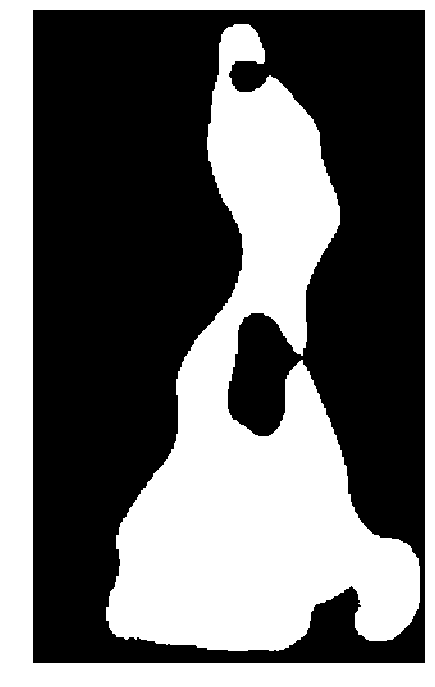

0


In [9]:
file_src_path = file_src_path_list[0]
div_x, div_y = 10, 10
off_x, off_y = -25, -50
img, div_pixel_x, div_pixel_y = img_arr(div_x, div_y, off_x, off_y, file_src_path)
section, section_white_num = split_img(img, div_pixel_x, div_pixel_y)

img_show(img)
# print(section[13,:,:])
# section_show(section, int(img.shape[0]/102), int(img.shape[1]/102))
print(section_white_num)


In [ ]:
div_x, div_y = 10, 10
offset_x, offset_y = np.arange(-80,80+10,10), np.arange(-80,80+10,10)

file_src_path = file_src_path_list[0]

a = 0
for off_x in offset_x:
    for off_y in offset_y:
        img, div_pixel_x, div_pixel_y = img_arr(div_x, div_y, off_x, off_y, file_src_path)
        # img_show(img)
        section, section_white_num = split_img(img, div_pixel_x, div_pixel_y)
        a = a + section_white_num
print(a)

In [ ]:
# === Function(Convert a PNG image into a pixel matrix) ===

def img_arr(div_x, div_y, off_x, off_y, file_path):
    if not isinstance(div_x, int) or div_x <= 0:
        raise ValueError("width divisor must be a positive integer")
    if not isinstance(div_y, int) or div_y <= 0:
        raise ValueError("height divisor must be a positive integer")
    try:
        with Image.open(file_path) as img:
            img = img.convert('L')
            img.load()
            width, height = img.size
            new_width = width-width % div_x
            new_height = height-height % div_y
            top_left, top_right = int(width % div_x/2), int(height % div_y/2)
            buttom_left, buttom_right = int(width/2+new_width/2), int(height/2+new_height/2)
            img = img.crop((top_left, top_right, buttom_left, buttom_right))
            # img = ImageChops.offset(img, off_x, off_y)
            new_img = np.array(img,np.uint8)  
            M = np.float32([[1, 0, off_x], [0, 1, off_y]])   
            output = cv.warpAffine(new_img, M, (new_img.shape[0], new_img.shape[1]))
            return output
    except OSError as e:
        raise OSError("Failed to open image file") from e
        
# ======
        
# ======
  
def section_show(section, div_x, div_y, figsize=(12,12)):
    rows = div_x
    cols = div_y            
    axes = []
    fig = plt.figure(figsize = figsize)

    for section_index in range(0,rows*cols):
        axes.append(fig.add_subplot(rows, cols, section_index+1))
        plt.imshow(section[section_index,:,:], cmap='gray')
        plt.text(0,0,section_index+1,fontsize=13,verticalalignment="top",horizontalalignment="right")
        plt.axis('off')
    fig.tight_layout()
        
# ======

In [ ]:
img_path = r'D:\\SuperBone_ver1.20_copy\\test\\test_sketeton_1.6.png'
img_edge_path = r'D:\\SuperBone_ver1.20_copy\\test\\test_sketeton_mask_1.6.png'
img = img_arr(div_x, div_y, off_x, off_y, img_path)
img_edge = img_arr(div_x, div_y, off_x, off_y, img_edge_path)

# === Step.8 split skeletonized image ===

image_width = img.shape[0]
image_height = img.shape[1]

x_positions = np.linspace(0, image_width, div_x+1) 
y_positions = np.linspace(0, image_height, div_y+1) 

section = np.zeros((int(div_x*div_y),int(image_width/div_x),int(image_height/div_y)))
section_edge = np.zeros((int(div_x*div_y),int(image_width/div_x),int(image_height/div_y)))

section_index = 0
for x in range(1,x_positions.shape[0]):
    for y in range(1,y_positions.shape[0]):
        section[section_index,:,:] = img[int(x_positions[x-1]):int(x_positions[x]),int(y_positions[y-1]):int(y_positions[y])]
        section_edge[section_index,:,:] = img_edge[int(x_positions[x-1]):int(x_positions[x]),int(y_positions[y-1]):int(y_positions[y])]
        section_index = section_index+1 
        


section_num = []
for i, (sub_section, sub_edge) in enumerate(zip(section, section_edge)):
    _, thresh = cv.threshold(sub_section,np.mean(sub_section),1,cv.THRESH_BINARY)
    img_size = thresh.size
    white_pixels = np.where(thresh>0)[0].shape[0]
    pixels_ratio = white_pixels/img_size
    if np.count_nonzero(sub_edge>0)==img_size and pixels_ratio>0.2:
        section_num.append(i+1)

section_all = np.zeros((len(section_num),section.shape[1],section.shape[2]))
j = 0
for i, sub_section in enumerate(section):
    if i+1 in section_num:
        section_all[j,:,:] = sub_section
        j = j+1  

print(section_num)

In [ ]:
image_width = output.shape[0]
image_height = output.shape[1]

print(image_width,image_height)

x_positions = np.arange(0, image_width+div_pixel, div_pixel) 
y_positions = np.arange(0, image_height+div_pixel, div_pixel) 

print(x_positions, y_positions)

div_x = x_positions.shape[0]-1
div_y = y_positions.shape[0]-1

section = np.zeros((int(div_x*div_y),int(div_pixel),int(div_pixel)))

section_index = 0
for x in range(1,x_positions.shape[0]):
    for y in range(1,y_positions.shape[0]):
        section[section_index,:,:] = output[int(x_positions[x-1]):int(x_positions[x]),int(y_positions[y-1]):int(y_positions[y])]
        section_index = section_index+1 
        
section_show(section, div_x, div_y)

section_num = 0
for i, sub_section in enumerate(section):
    pixels_all = np.count_nonzero(sub_section>0)
    if pixels_all==div_pixel*div_pixel:
        section_num = section_num+1
print(section_num)

In [ ]:
image_width = crop_img.shape[0]
image_height = crop_img.shape[1]
div_x, div_y = int(image_width/div_pixel), int(image_height/div_pixel)
off_x, off_y = 50, 50

x_positions = np.arange(0,image_width+div_pixel,div_pixel)+off_x
x_positions[0] = 0
x_positions[x_positions.shape[0]-1] = image_width

y_positions = np.arange(0,image_height+div_pixel,div_pixel)+off_y
y_positions[0] = 0
y_positions[y_positions.shape[0]-1] = image_height
print(x_positions, y_positions)

In [ ]:
# ======

"""
======
Get the width and height of the terminal window.
======
"""

width, height = shutil.get_terminal_size((80, 20))

# ======

# ======

"""
    :param work_dir (str) : Current working directory
    :param main_dir (str) : Always be set to ./SuperBone_ver1
    :param output_dir (str) : The default directory where all outputs are stored
"""  

work_dir = os.getcwd()
main_dir = os.path.dirname(work_dir)
initial_dir = os.path.join(main_dir,'test')  
output_dir = os.path.join(main_dir,'test')

# ======

import FileChooser

"""
======
Initialize the class and set the initial directory, file type, and the type of file/folder to choose
======
    :param initial_dir (str) : Initial directory to open the file dialog
    :param file_type (str) : The type of file to select (e.g. "Image", "DICOM",...)
    :param choose_type (str) : The type of file/folder to select ("File", "Folder", "Multiple Files")
"""  

selector = FileChooser.Selector(initial_dir, file_type = "PNG", choose_type = "File")

# ======

"""
======
Open a file dialog windows and return the source path
    :param file_src_path (str) : The absolute path of the source image
======
"""

file_src_path = selector.run()

# ======

In [ ]:
import re
work_dir = os.getcwd()
main_dir = os.path.dirname(work_dir)
initial_dir = os.path.join(main_dir,'test')  
output_dir = os.path.join(main_dir,'test')

file_src_path_list = [os.path.join(output_dir, file) for file in os.listdir(output_dir) 
                      if re.match('test_sketeton_mask_\d.\d+.png',file)]
file_src_path_list = sorted(file_src_path_list)


file_src_path_edge_list = [os.path.join(output_dir, file) for file in os.listdir(output_dir) 
                           if re.match('test_sketeton_edge_\d.\d.png',file)]
file_src_path_edge_list = sorted(file_src_path_edge_list)

print(len(file_src_path_list))

In [ ]:
import statistics

div_x, div_y = 10, 10
off_x, off_y = 0, 0

i = 1
for file_src_path, file_src_path_edge in zip(file_src_path_list, file_src_path_edge_list):
    
    if i <=2:
        img = img_arr(div_x, div_y, off_x, off_y, file_src_path)
        img_edge = img_arr(div_x, div_y, off_x, off_y, file_src_path_edge)

        x,y,w,h = cv.boundingRect(img_edge)

        img_div_width = img.shape[0]/div_x
        img_div_height = img.shape[1]/div_y

        if w>img_div_width and h>img_div_height:
            section = split_img(img)
            section_edge = split_img(img_edge)
            section_all = split_all_img(section, section_edge) 
            # print(section_all.shape[0],section_all.shape[1])
            section_show(section, div_x, div_y)
            k = []
            for a in section_all:
                pixels_white = np.where(a>0)[0].shape[0]
                pixels_black = np.where(a==0)[0].shape[0]
                porosity = pixels_black/(pixels_white+pixels_black)  
                k.append(porosity)

            if len(k)>0:
                mean = statistics.mean(k)
                st_dev = statistics.pstdev(k)
                print(i, section_all.shape[0], round(mean,3), round(st_dev,3))

                plt.scatter(i,round(st_dev,3))
    i = i+0.1    

In [ ]:
import statistics

div_x, div_y = 12, 12
off_x, off_y = 0, 0

i = 1
for file_src_path, file_src_path_edge in zip(file_src_path_list, file_src_path_edge_list):
    
    img = img_arr(div_x, div_y, off_x, off_y, file_src_path)
    img_edge = img_arr(div_x, div_y, off_x, off_y, file_src_path_edge)

    x,y,w,h = cv.boundingRect(img_edge)
    
    img_div_width = img.shape[0]/div_x
    img_div_height = img.shape[1]/div_y

    if w>img_div_width and h>img_div_height:
        section = split_img(img)
        section_edge = split_img(img_edge)
        section_all = split_all_img(section, section_edge) 
        # print(section_all.shape[0],section_all.shape[1])
        # section_show(section, div_x, div_y)
        k = []
        for a in section_all:
            pixels_white = np.where(a>0)[0].shape[0]
            pixels_black = np.where(a==0)[0].shape[0]
            porosity = pixels_black/(pixels_white+pixels_black)  
            k.append(porosity)
        
        if len(k)>0:
            mean = statistics.mean(k)
            st_dev = statistics.pstdev(k)
            print(i, section_all.shape[0], round(mean,3), round(st_dev,3))
            
            plt.scatter(i,round(mean,3))
    i = i+0.1    

In [ ]:
import statistics

div_x_array, div_y_array = np.arange(100,1,-1), np.arange(100,1,-1)
off_x, off_y = 0, 0

for div_x, div_y in zip(div_x_array, div_y_array):
    
    img = img_arr(div_x.item(), div_y.item(), off_x, off_y, file_src_path)
    img_edge = img_arr(div_x.item(), div_y.item(), off_x, off_y, file_src_path_edge)

    edge,x,y,w,h = edge_detect(img)

    img_div_width = img.shape[0]/div_x.item()
    img_div_height = img.shape[1]/div_y.item()

    if w>img_div_width and h>img_div_height:
        section = split_img(img)
        section_edge = split_img(img_edge)
        section_all = split_all_img(section, section_edge)       
        # print(section_all.shape[0],section_all.shape[1])
        k = []
        for a in section_all:
            pixels_white = np.where(a>0)[0].shape[0]
            pixels_black = np.where(a==0)[0].shape[0]
            porosity = pixels_black/(pixels_white+pixels_black)  
            k.append(porosity)
        
        if len(k)>0:
            mean = statistics.mean(k)
            st_dev = statistics.pstdev(k)
            print(div_x, section_all.shape[0], round(mean,3), round(st_dev,3))
            
            plt.scatter(section_all.shape[0],round(mean,3))

In [ ]:
img_show(section[66,:,:])
print(section[66,:,:].shape)